# Tip: Natural Language Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils, plot_help
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
import nltk

import re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import mglearn

%matplotlib inline

In [2]:
#modify read_limit and chunk_size parameters based on memory capacity
df = utils.chunk_loader('data/tip.json', read_limit=50000)
df.head()

,business_id,compliment_count,date,text,user_id
0,VaKXUpmWTTWDKbpJ3aQdMw,0,2014-03-27 03:51:24,"Great for watching games, ufc, and whatever el...",UPw5DWs_b-e2JRBS-t37Ag
1,OPiPeoJiv92rENwbq76orA,0,2013-05-25 06:00:56,Happy Hour 2-4 daily with 1/2 price drinks and...,Ocha4kZBHb4JK0lOWvE0sg
2,5KheTjYPu1HcQzQFtm4_vw,0,2011-12-26 01:46:17,Good chips and salsa. Loud at times. Good serv...,jRyO2V1pA4CdVVqCIOPc1Q
3,TkoyGi8J7YFjA6SbaRzrxg,0,2014-03-23 21:32:49,The setting and decoration here is amazing. Co...,FuTJWFYm4UKqewaosss1KA
4,AkL6Ous6A1atZejfZXn1Bg,0,2012-10-06 00:19:27,Molly is definately taking a picture with Sant...,LUlKtaM3nXd-E4N4uOk_fQ


In [3]:
df.shape

(50000, 5)

In [4]:
df.dtypes

business_id                 object
compliment_count             int64
date                datetime64[ns]
text                        object
user_id                     object
dtype: object

In [5]:
df['text'][42]

'Lots of people on the second floor!'

In [6]:
text_len = [len(x) for x in df['text']]

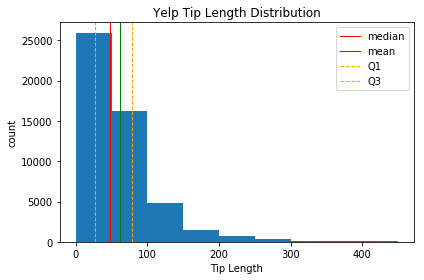

In [7]:
plot_help.plot_hist(pd.Series(text_len),end=500, step=50,
                    feature='Tip Length', xlabel='Tip Length',
                    saveloc='plots/tip_length.png')

In [8]:
df.nunique()

business_id         25802
compliment_count        7
date                49971
text                49096
user_id             17139
dtype: int64

In [9]:
df.compliment_count.value_counts()

0    49069
1      830
2       81
3       13
4        4
5        2
6        1
Name: compliment_count, dtype: int64

### Word Cloud

In [10]:
#Combine all the reviews into one massive string
review_text_combined = " ".join(review for review in df['text'])
print ("There are {} words in the combination of all reviews.".format(len(review_text_combined)))

There are 3163718 words in the combination of all reviews.


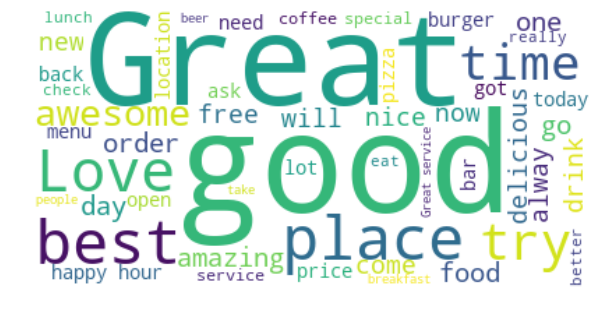

In [11]:
# Create stopword list:
stopwords = set(STOPWORDS)
#For now let's only remove the
stopwords.update(["the"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      width= 400, height = 200, 
                      max_words=50).generate(review_text_combined)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('plots/tip_word_cloud.png')
plt.show()

### Bag of Words

In [12]:
#instantiate the countvectorizer and assume minimum frequenct is 3
vect = CountVectorizer(min_df=3, stop_words="english")

#fit the corpus
vect.fit(df['text'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
print("Vocab size = {}".format(len(vect.vocabulary_)))

Vocab size = 8683


In [14]:
#create bag of words
bag_of_words = vect.transform(df['text'])

In [15]:
#number of features to see
k=20
feature_names = vect.get_feature_names()
print("Number of features = {}".format(len(feature_names)))
print("First {} features: \n{}".format(k, feature_names[:k]))

Number of features = 8683
First 20 features: 
['00', '000', '00am', '00pm', '01', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '101', '1030', '105', '10a', '10am']


### tf-idf

In [16]:
def stem_sentences(sentence):
    
    """
    Helper function to stem text with PorterStemmber and Lemmatizer
    """
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    
    tokens = sentence.split()
    
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    
    lemmed_tokens = [lemmatizer.lemmatize(token, pos='n') for token in stemmed_tokens]
    lemmed_tokens = [lemmatizer.lemmatize(token, pos='v') for token in lemmed_tokens]
    
    return ' '.join(lemmed_tokens)

In [17]:
with open('french_stop_words.txt') as f:
    french_stop_words = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
french_stop_words = [x.strip() for x in french_stop_words] 

In [18]:
#french words to remove
fr_pat = r'\b(?:{})\b'.format('|'.join(french_stop_words))

#take out french words
text_no_fr = df['text'].str.replace(fr_pat, '')

#create a stemmed version of review text
text_stem = df['text'].apply(stem_sentences)

In [19]:
#instantiate tfidf object
tfidf = TfidfVectorizer(stop_words="english", min_df=2).fit(text_stem)

#transform and fit text
tfidf_text = tfidf.transform(text_stem)

In [20]:
#get feature array
feature_array = np.array(tfidf.get_feature_names())

#get sorted indeces
tfidf_sorting = np.argsort(tfidf_text.toarray()).flatten()[::-1]

k_tfidf = 20
print("{} features with HIGHEST tifdf: \n{}".format(k_tfidf, feature_array[tfidf_sorting][:k_tfidf]))
print("{} features with LOWEST tifdf: \n{}".format(k_tfidf, feature_array[tfidf_sorting][-k_tfidf:]))


20 features with HIGHEST tifdf: 
['24' 'location' 'hour' 'éviter' 'fade' 'faint' 'failur' 'fails' 'failed'
 'fail' 'fades' 'faculti' 'faire' 'factory' 'factori' 'factor' 'fact'
 'fack' 'facility' 'facilities']
20 features with LOWEST tifdf: 
['pickin' 'pickl' 'pierogi' 'pierced' 'pierc' 'pieces' 'piece' 'piec'
 'pie' 'pide' 'pictures' 'pictured' 'picture' 'pictur' 'pics' 'pico'
 'picnic' 'pickup' 'pickles' '00']


## Latent Dirichlet Allocation

In [21]:
#  ignore terms that have a document frequency strictly higher than the given threshold by max_df
#instantiate count vect object
vect_lda = CountVectorizer(max_features=10_000, max_df=0.20)

In [22]:
lda_text = vect_lda.fit_transform(df['text'])

In [23]:
#instantiate LDA object
lda = LatentDirichletAllocation(n_components=10,
                                learning_method='batch',
                                max_iter=30,
                                random_state=42)

# Computing transform takes some time so fit + transform in one step
lda_topics = lda.fit_transform(lda_text)

In [24]:
#see shape
lda.components_.shape

(10, 10000)

In [25]:
#sort features for each top
# Invert rows with [:, ::-1] to make sorting descending
lda_sort_topics = np.argsort(lda.components_, axis=1)[:, ::-1]

#get feature names
lda_feat_names = np.array(vect_lda.get_feature_names())

In [26]:
# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), 
                           feature_names=lda_feat_names,
                           sorting=lda_sort_topics, 
                           topics_per_chunk=5, 
                           n_words=10)


topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
best          it            for           for           great         
is            here          is            lunch         food          
chicken       not           coffee        happy         service       
are           was           tea           hour          good          
in            but           free          menu          is            
try           so            ice           special       very          
of            like          with          beer          friendly      
delicious     to            only          on            was           
with          that          cream         99            staff         
their         they          try           sushi         nice          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
this

In [28]:
#see sample reviews from topic k
topic_k = 0

topic_k_list = np.argsort(lda_sort_topics[:, topic_k])[::-1]

# print the five documents where the topic is most important 
for i in topic_k_list[:10] :
    # pshow first two sentences
    print(df['text'][i])
    print('\n')
    
    

Only worth a visit in the summer time, to take advantage of the huge sun soaked patio.


It's true! The drunken noodles are outrageous!


Okay so I had a groupon for a nearby service center, but their wait time was 3 hours! Once again, I find myself back at this Brake Masters. Idk why I bother with anywhere else; This place is great!


Sat in the drive thru this afternoon for 30 minutes and then was handed the wrong coffee. Booooo, I'm seriously here every day and this was the first bad experience


Hands down best AYCE in town! Love it!


Happy Hour 2-4 daily with 1/2 price drinks and slushes AND after 8 half price shakes.  They actually have a peanut butter and bacon shake.


Molly is definately taking a picture with Santa lols


The setting and decoration here is amazing. Come check out the waterfall fountain in the middle!


Good chips and salsa. Loud at times. Good service. Bathrooms AWFUL. So that tanks my view on this place.


Great for watching games, ufc, and whatever else tic